In [41]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [42]:
import datetime as dt
from os import environ

from google.cloud import bigquery
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
from sklearn import tree

from helper import mean_impute

In [43]:
style.use('dark_background') # make plots readable in vscode
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

In [44]:
if not environ.get('GOOGLE_APPLICATION_CREDENTIALS'):
    environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/backes/Downloads/learnings-350114-5842405dcd8d.json'

In [45]:
bqclient = bigquery.Client()

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information form over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 13 years ago. So if today is 2022.02.15 then the weather we want to forecast is for the date 2009.02.16. You are suppsed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to used BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is, to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck at the first part, you can use the replacement data provided in the second part

In [46]:
%%bigquery 
SELECT
*,
FROM `bigquery-public-data.samples.gsod`
LIMIT 20 


Downloading: 100%|██████████| 20/20 [00:01<00:00, 11.63rows/s]


,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,39730,99999,1929,10,20,52.799999,4,45.500000,4,NaN,...,NaN,<NA>,0.0,NaN,False,False,False,False,False,False
1,33110,99999,1929,12,18,47.500000,4,44.000000,4,NaN,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
2,37770,99999,1931,4,24,50.200001,4,44.299999,4,NaN,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
3,726810,24131,1931,6,23,65.099998,24,41.500000,8,NaN,...,NaN,<NA>,0.0,NaN,False,False,False,False,False,False
4,726810,24131,1931,3,2,42.799999,24,31.500000,8,NaN,...,NaN,<NA>,0.0,NaN,False,False,False,False,False,False
5,726810,24131,1931,9,17,67.000000,24,40.500000,8,NaN,...,NaN,<NA>,0.0,NaN,False,False,False,False,False,False
6,726810,24131,1931,8,7,68.400002,24,37.200001,8,NaN,...,NaN,<NA>,0.0,NaN,False,False,False,False,False,False
7,726810,24131,1932,7,14,64.099998,24,54.099998,8,NaN,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
8,726810,24131,1932,10,23,41.099998,24,31.000000,8,NaN,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
9,726810,24131,1932,1,5,24.600000,24,21.100000,8,NaN,...,NaN,<NA>,NaN,NaN,True,True,True,True,True,True


## Part 1

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2005 till 2009 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [47]:
query_string = """
SELECT
*,
CONCAT(year,'-',LPAD(CAST(month AS STRING), 2, '0'),'-',LPAD(CAST(day AS STRING),2,'0')) as date
FROM `bigquery-public-data.samples.gsod`
WHERE year BETWEEN 2005 AND 2009
AND station_number BETWEEN 725300 AND 726300
ORDER BY date ASC
"""
df_original = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)
# note: query is in addition ordered by date so that downstream code doesn't have to order it all the time

### 2. Task 
From here want to work with the data from all stations 725300 to 725330 that have information from 2005 till 2009. 

Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate. 

## Data Cleaning
Before looking at the data we need to understand the individual columns. For some reason, metadata queries do not work with public datasets: `SELECT * FROM bigquery-public-data.samples.gsod.INFORMATION_SCHEMA`, so the descriptions are copied manually from: https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=gsod&page=table (only non-obvious columns explained)

- station_number: The World Meteorological Organization (WMO) / DATSAV3 station number where the data was collected. 
- wban_number: The Weather-Bureau-Army-Navy (WBAN) station number where the data was collected. 
- mean_temp: The mean temperature of the day in degrees Fahrenheit, accurate to one tenth of a degree. 
- num_mean_temp_samples: The number of observations used to calculate mean_temp.
- mean_sealevel_pressure: The mean sea level pressure of the day in millibars, accurate to one tenth of a millibar 
- mean_visibility: The mean visibility of the day in miles, accurate to one tenth of a mile. 
- mean_wind_speed: The mean wind speed of the day in knots, accurate to one tenth of a knot. 
- max_sustained_wind_speed: The maximum sustained wind speed reported on the day in knots, accurate to one tenth of a knot. 
- max_gust_wind_speed: The maximum wind gust speed reported on the day in knots, accurate to one tenth of a knot 
- max_temperature: The maximum temperature of the day in degrees Fahrenheit, accurate to one tenth of a degree. The time that this value is reported differs by country and region, so this value will sometimes not be the maximum for the calendar day.
- max_temperature_explicit: Indicates the source of max_temperature. 
- total_precipitation: The total precipitation of the day in inches, accurate to one hundredth of an inch. 
- snow_depth: The snow depth of the day in inches, accurate to one tenth of an inch. 
- fog: Indicates if fog was reported on this day. 


[Maximum sustained wind speed](https://en.wikipedia.org/wiki/Maximum_sustained_wind): Wind speed relevant for tropical cyclones
[Wind gust](https://en.wikipedia.org/wiki/Wind_gust): Brief increase of wind, typically less than 20s

From the descriptions, the following changes will be done:
- Transform Fahrenheit to Celsius to make the results easier to interpret for my European brain
- Transform miles to meters
- Transform knots to km/h
- Transform inches to cm
- Try to drop either station_number or wban_number as they seem to contain redundant information. Maybe give the stations a custom unique key and drop both
- Drop min_temperature_explicit and max_temperature_explicit as I do not understand what this column means

Note that we'll keep the data s well as individual year, month, day columns even though they contain redundant information. The individual columns might be more useful during model training than the date string.

In [48]:
df = df_original.copy() # copy df such that the slow (and expensive) query doesn't need to be re-run

In [49]:
# convert Fahrenheit to Celsius according to: https://www.rapidtables.com/convert/temperature/fahrenheit-to-celsius.html
df['mean_temp'] = (df['mean_temp']-32)*(5/9)
df['mean_dew_point'] = (df['mean_dew_point']-32)*(5/9)
df['max_temperature'] = (df['max_temperature']-32)*(5/9)
df['min_temperature'] = (df['min_temperature']-32)*(5/9)

In [50]:
# convert miles to meters according to: https://www.rapidtables.com/convert/length/mile-to-meter.html
df['mean_visibility'] = df['mean_visibility']*1609.344

In [51]:
# convert knots to km/h
df['mean_wind_speed'] = df['mean_wind_speed']*1.852
df['max_sustained_wind_speed'] = df['max_sustained_wind_speed']*1.852
df['max_gust_wind_speed'] = df['max_gust_wind_speed']*1.852

In [52]:
# convert inches to cm according to: https://www.rapidtables.com/convert/length/inch-to-cm.html
df['total_precipitation'] = df['total_precipitation']*2.54
df['snow_depth'] = df['snow_depth']*2.54

In [53]:
# drop max_temperature_explicit
df = df.drop(columns=('max_temperature_explicit'))
df = df.drop(columns=('min_temperature_explicit')); # add ; to hide output

In [54]:
# analyse station_number or wban_number
print("NaNs in station_number:", df['station_number'].isnull().any(), "NaNs in wban_number:", df['wban_number'].isnull().any())
## if there are the same nbr. of station_number than wban_number, then we can assume that all stations have both ids
print("Unique station_number:", len(df['station_number'].unique()), "Unique wban_number:", len(df['wban_number'].unique()))

## check if there is a station number with multiple wban_numbers, and vice versa
station_to_multiple_wbans = 0
wban_to_multiple_stations = 0
unique_stations_for_wban = 0

groups = df.groupby('station_number')
for name, group in groups:
    if group.nunique()['wban_number'] > 1:
        station_to_multiple_wbans += 1

groups = df.groupby('wban_number')
for name, group in groups:
    if (unique_stations_for_wban := group.nunique()['station_number']) > 1:
        wban_to_multiple_stations += 1

print("station_to_multiple_wbans:", station_to_multiple_wbans, "wban_to_multiple_stations:", wban_to_multiple_stations, ", maps to", unique_stations_for_wban, "distinct station")

NaNs in station_number: False NaNs in wban_number: False
Unique station_number: 217 Unique wban_number: 204
station_to_multiple_wbans: 126 wban_to_multiple_stations: 1 , maps to 140 distinct station


As it turns out, there is no clear 1-1 relationship between wban and station number. For the sake of time, we'll drop the wban column and just work with the station_number column as this is the identifier requested by the challenge.

In [55]:
# drop wban number
df = df.drop(columns=('wban_number'));

The next step is a combination of exploratory analysis and data cleaning/imputation as we can not just blindly drop all the NaNs

In [56]:
df.isna().any()


station_number                        False
year                                  False
month                                 False
day                                   False
mean_temp                             False
num_mean_temp_samples                 False
mean_dew_point                         True
num_mean_dew_point_samples             True
mean_sealevel_pressure                 True
num_mean_sealevel_pressure_samples     True
mean_station_pressure                  True
num_mean_station_pressure_samples      True
mean_visibility                        True
num_mean_visibility_samples            True
mean_wind_speed                        True
num_mean_wind_speed_samples            True
max_sustained_wind_speed               True
max_gust_wind_speed                    True
max_temperature                        True
min_temperature                        True
total_precipitation                    True
snow_depth                             True
fog                             

In [57]:
df[df.columns[df.isnull().any()]]

,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,min_temperature,total_precipitation,snow_depth
0,-2.777778,24,NaN,<NA>,NaN,<NA>,16093.440000,24,11.852800,24,24.076000,29.446799,-2.000000,NaN,0.0000,NaN
1,-4.166667,24,NaN,<NA>,NaN,<NA>,16093.440000,24,9.630400,24,29.446799,38.892000,-4.000000,NaN,0.0000,NaN
2,-2.055556,24,1004.900024,19,NaN,<NA>,1287.475219,24,16.482799,24,22.224000,35.188000,-1.000000,NaN,0.8636,20.066
3,-9.277778,24,1010.000000,24,NaN,<NA>,15932.504986,24,20.001600,24,51.856000,64.820000,-6.111111,NaN,0.0000,NaN
4,-4.444444,24,1006.400024,20,NaN,<NA>,12874.752000,24,16.853201,24,31.298799,NaN,-9.388889,NaN,0.1016,5.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377779,-5.055556,24,NaN,<NA>,NaN,<NA>,9334.195507,24,12.593600,24,25.928000,35.188000,-8.000000,NaN,NaN,NaN
377780,-13.388889,24,NaN,<NA>,NaN,<NA>,12713.817753,24,15.556799,24,31.298799,38.892000,-16.000000,NaN,NaN,NaN
377781,-9.388889,24,1021.400024,16,NaN,<NA>,10299.801753,24,19.446000,24,29.446799,40.744000,-12.222222,NaN,0.1524,NaN
377782,-13.444444,24,NaN,<NA>,NaN,<NA>,13035.687014,24,17.408799,24,31.298799,38.892000,-16.000000,NaN,NaN,NaN


## snow_depth
The NaN at show_depth might be that no snow fell on that day and that the height is 0. To confirm this, we could plot the snow and snow_depth variables side-by-side. It could also be the case that certain stations didn't record this.

As it turns out, the majority of stations didn't record any snow_depth even though they all recorded whether it snowed. Therefore, this column will be dropped.

In [58]:
groups = df.groupby('station_number', as_index = False)
stations_with_no_depth = 0
stations_with_no_snow = 0
for name, group in groups:
    if group['snow_depth'].count() == 0:
        stations_with_no_depth += 1

for name, group in groups:
    if group['snow'].count() == 0:
        stations_with_no_snow += 1
print("stations with no snow_depth:", stations_with_no_depth, "stations with no snow", stations_with_no_snow, "total number of stations:", len(df['station_number'].unique()))

stations with no snow_depth: 188 stations with no snow 0 total number of stations: 217


In [59]:
df = df.drop(columns=('snow_depth'))

## min_temperature
This column is only NaNs and will be dropped. This is very unfortunate, as I expected it to have at least some predictive power for the task at hand :(

In [60]:
print("non-NaN values of min_temperature:", df['min_temperature'].count())
df = df.drop(columns=('min_temperature'))

non-NaN values of min_temperature: 0


## num_mean_XX_samples
It is not immediately clear how num_mean_station_pressure_samples, num_mean_visibility_samples, num_mean_wind_speed_samples,... help for predictions so we'll drop them.

In [61]:
df = df.drop(columns=('num_mean_temp_samples'))
df = df.drop(columns=('num_mean_dew_point_samples'))
df = df.drop(columns=('num_mean_sealevel_pressure_samples'))
df = df.drop(columns=('num_mean_station_pressure_samples'))
df = df.drop(columns=('num_mean_visibility_samples'))
df = df.drop(columns=('num_mean_wind_speed_samples'))

## mean_XX_pressure
The majority of mean_station_pressure entries are NaNs and this column will be dropped. Around 38% of stations don't contain any sealevel pressure. In order to not drop _all_ the possible predictors, we'll drop these stations and keep the column.


mean_sealevel_pressure still contains many NaNs. The question is whether all stations contain some NaN values, or some stations contain only NaN values. In the former case, imputation with nearby days could be used and can be quickly verified with a plot. In the latter, the stations can be dropped if it's not too many.

In [62]:
print('Fraction of non-NaN values of station_pressure:',  df['mean_station_pressure'].count()/df['mean_station_pressure'].shape[0], 'Fraction of non-NaN values of sealevel_pressure:', df['mean_sealevel_pressure'].count()/df['mean_sealevel_pressure'].shape[0])
df = df.drop(columns=('mean_station_pressure'))

Fraction of non-NaN values of station_pressure: 0.0230687376913792 Fraction of non-NaN values of sealevel_pressure: 0.6139407703873113


In [63]:
groups = df.groupby('station_number', as_index = False)
no_sealevel_pressure= 0
for name, group in groups:
    if group['mean_sealevel_pressure'].count() == 0:
        no_sealevel_pressure += 1

print("stations with no sealevel_pressure:", no_sealevel_pressure, "fraction:", no_sealevel_pressure/df['station_number'].nunique())

stations with no sealevel_pressure: 84 fraction: 0.3870967741935484


In [64]:
groups = df.groupby('station_number', as_index = False)
no_sealevel_pressure= 0
no_pressure_list = []
for name, group in groups:
    if group['mean_sealevel_pressure'].count() == 0:
        no_pressure_list.append(name)
        no_sealevel_pressure += 1
df = df.drop(df[df['station_number'].isin(no_pressure_list)].index)

There are still some NaNs for sealevel_pressure. They can be imputed with the mean of nearby days 

In [65]:
df['mean_sealevel_pressure'] = mean_impute(df, 'mean_sealevel_pressure')

## remaining columns
Due to time constraints, the remaining columns will be imputed the same way

In [66]:
df['mean_dew_point'] = mean_impute(df, 'mean_dew_point')
df['mean_visibility'] = mean_impute(df, 'mean_visibility')
df['mean_wind_speed'] = mean_impute(df, 'mean_wind_speed')
df['total_precipitation'] = mean_impute(df, 'total_precipitation')
df['max_temperature'] = mean_impute(df, 'max_temperature')

## max_*_wind_speed
Besides max_wind_speed, there are two other columns: max_sustained_wind_speed and max_gust_wind_speed. All three of them are most probably highly correlated and only one of the three is required. With more time, I'd keep all of them in the model and see whether some of them get dropped during a feature selection step. Due to the time limit I'll drop max_sustained_wind_speed and max_gust_wind_speed. I chose these two because I understand their meaning the least.

In [67]:
df = df.drop(columns=('max_sustained_wind_speed'))
df = df.drop(columns=('max_gust_wind_speed'))

In [68]:
df_cleaned = df.copy()

### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for is the following, and hence should constitute your test set.

In [69]:
str(dt.datetime.today()- dt.timedelta(days=13*365)).split(' ')[0]

'2009-05-18'

Test set: randomly select 10% of stations which are not used during, plotting,... at all. The train/validation splits will be done later.

In [70]:
test_set_stations = np.random.choice(df_cleaned['station_number'].unique(), size = len(df_cleaned['station_number'].unique())//10, replace=False)

In [71]:
df = df_cleaned[~df_cleaned['station_number'].isin(test_set_stations)]

In [72]:
# make sure that we didn't mess up this step as it'll invalidate everything if we accidentally train on the holdout data
assert(df_cleaned['station_number'].nunique() > df['station_number'].nunique()) 

## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an Algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [73]:
str(dt.datetime.today()- dt.timedelta(days=13*365)).split(' ')[0]

'2009-05-18'

You are allowed to use any library you are comfortable with such as sklearn, tensorflow keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

### Markov Chain
Train one of the most simple models: A Markov chain per site. Many choices to build one, so let's just predict the probability of snow followed by rain. During this process it turned out, that the data has an issue and the rain and snow columns are equal!

Code for this is adapted from: https://github.com/eliekayitare/Markov_chain_weather_prediction/blob/master/weather_prediction.ipynb

Note that this returns a probability. To convert this into a "yes"/"no" answer we have to choose a threshold, such as 75%.

In [74]:
# Code to test out the method on a single station

df_tmp = df[df['station_number'] == df['station_number'].iloc[0]]
total_days = df_tmp.shape[0]

# proba of snow after snow
snow_after_snow_counter = 0
snow_previous = False # assumption, could also be run with True and compared
for idx, day in df_tmp.iterrows():
    # This assumes that there are no missing days... Should be checked
    if day['snow'] and snow_previous:
        snow_after_snow_counter += 1
    snow_previous = day['snow']

proba_snow_after_snow = snow_after_snow_counter/total_days
proba_snow_after_rain = 1-proba_snow_after_snow
print("Probability to snow after snowing:", proba_snow_after_snow, "Probability to snow after raining:", proba_snow_after_rain)



# proba of rain_after_snow
rain_after_rain_counter = 0
rain_previous = False
for idx, day in df_tmp.iterrows():
    if day['rain'] and rain_previous:
        rain_after_rain_counter += 1
    rain_previous = day['rain']

proba_rain_after_rain = rain_after_rain_counter/total_days
proba_rain_after_snow = 1-proba_rain_after_rain
print("Probability to rain after raining:", proba_rain_after_rain, "Probability to rain after snowing:", proba_rain_after_snow) 

Probability to snow after snowing: 0.3313153549807375 Probability to snow after raining: 0.6686846450192625
Probability to rain after raining: 0.3313153549807375 Probability to rain after snowing: 0.6686846450192625


In [75]:
df['rain'].equals(df['snow'])

True

In [76]:
df_original['rain'].equals(df_original['snow'])

True

# Pseudocode to save time. validation implementation for the markov chain
# This can also be used for features selection. Are snow/rain the correct two states? What about snow/fog? snow/wind? What about more states?

# treat stations independently
for station in stations:
    # run model validation: Chose a random date and train the model from start date up to that date. Then predict the following date
    # Note that for model convergence it probably doesn't make sense to have a cutoff-date too early
    cutoff_index = np.randint(30, num_of_days) 
    train_data = station.iloc[0:cutoff_index]
    test_data = station.iloc[cutoff_index:]

    probabilities = fit_markov_chain(train_data)
    # The model got trained from 0:cutoff . Therefore, we can test from cutoff:num_of_days and get an array as result
    does_it_snow = predict(probabilities, test_data)
    num_of_correct = (test_data['snow'] == does_it_snow).sum()
    print("Correct predictions:", num_of_correct, "fraction:", num_of_correct/test_data.shape[0])
    

Assuming that rain and snow data were correct, why is the model bad? We disregard seasonality. As rain has more or less the same probability in each month, the probability of snow after rain is therefore also the same for each month. To improve this model, a different feature needs to be used which captures seasonality, such as the temperature. Alternatively the data can be split up into groups of months or the four seasons and a chain per season is created.

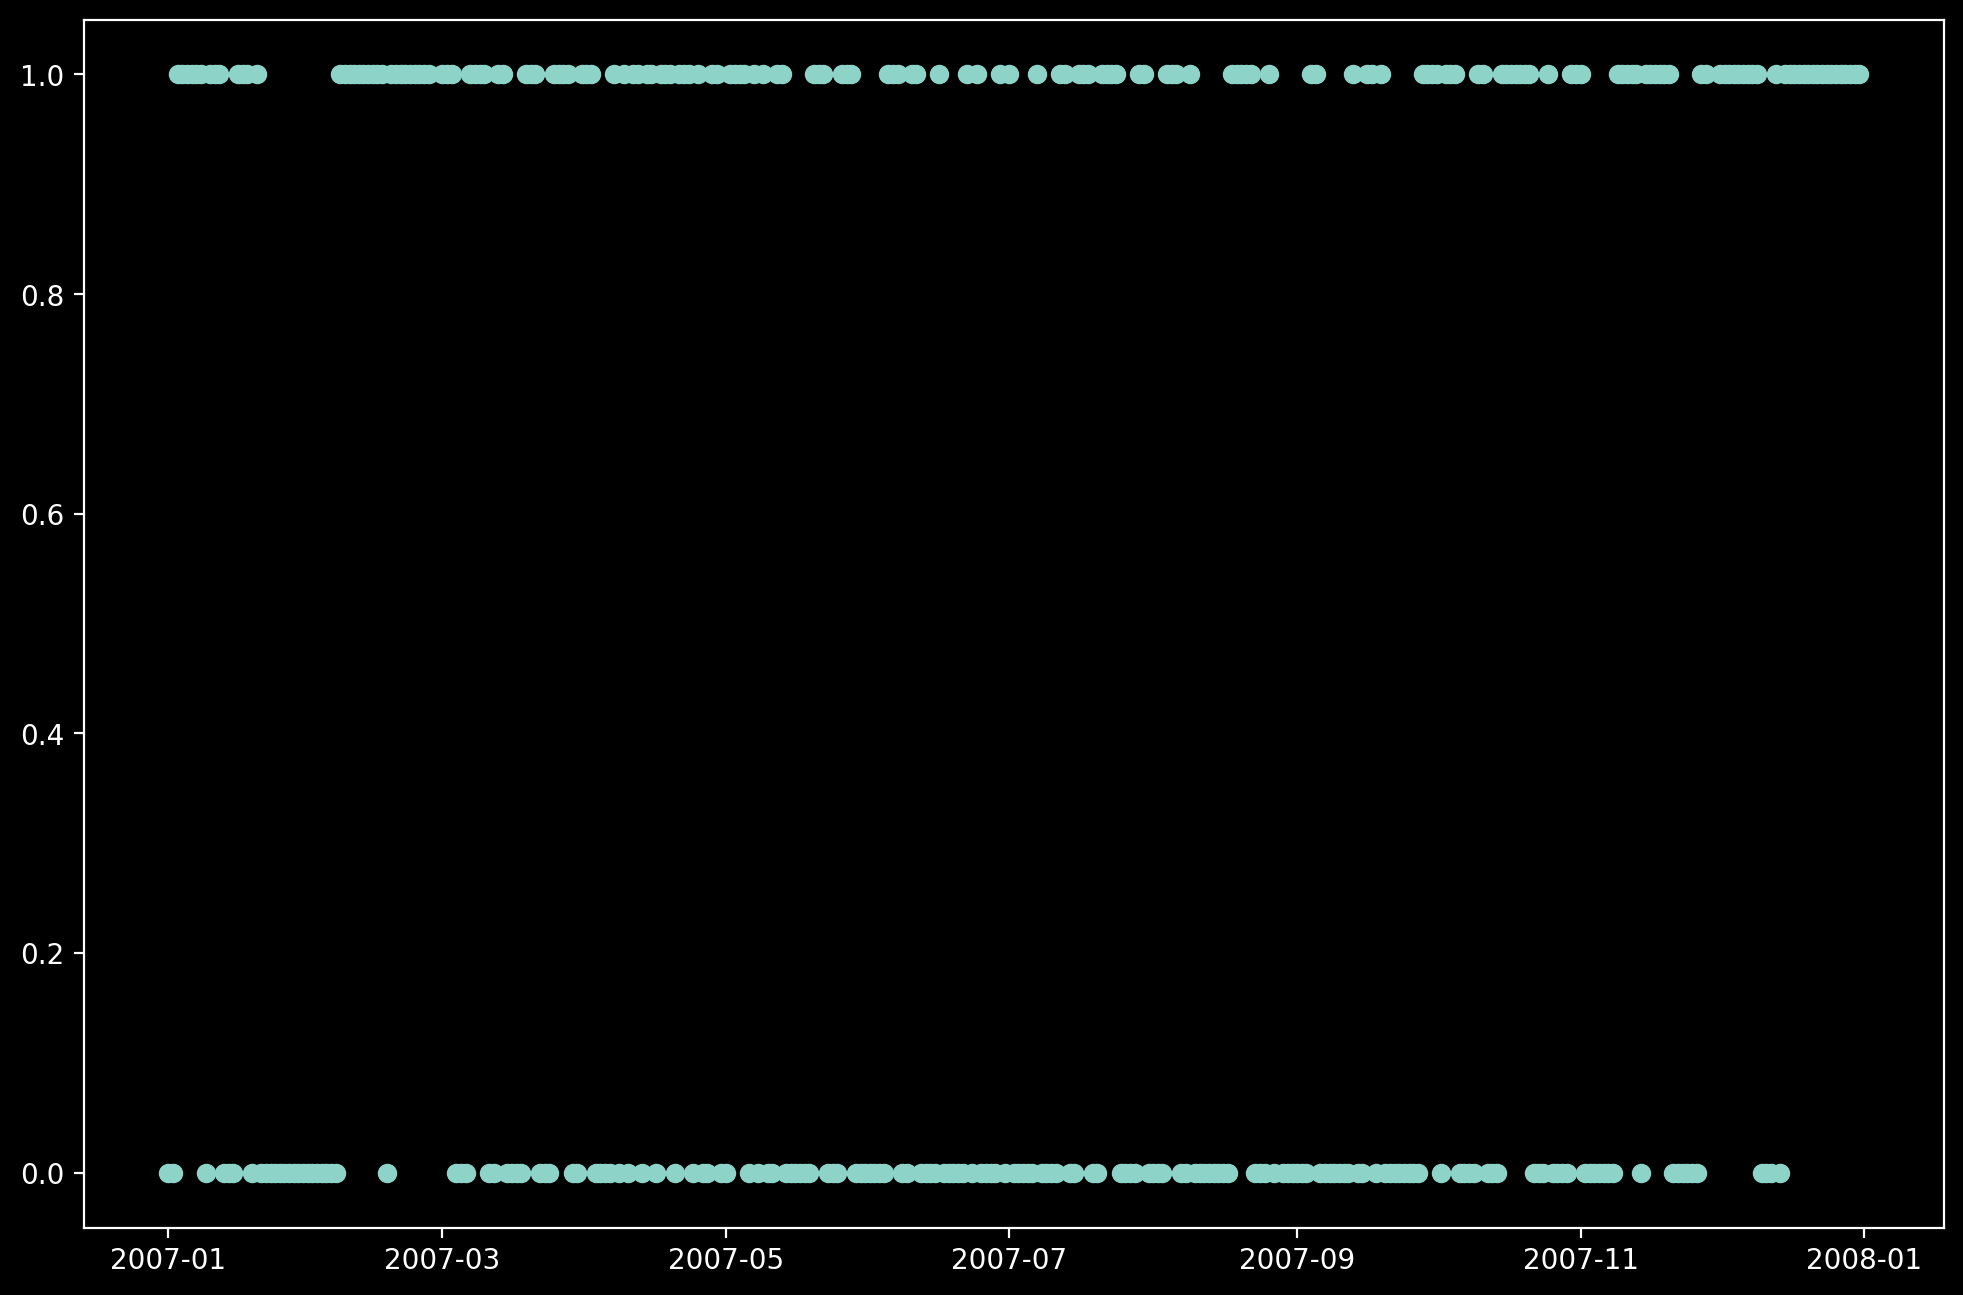

In [77]:
# Visualization that every month has more or less the same probability of rain, and rain therefore doesn't track seasonality
df_tmp = df[df['station_number'] == df['station_number'].iloc[0]]
df_tmp = df_tmp[df_tmp['year'] == 2007]
ax = plt.gca()
ax.xaxis_date()
plt.scatter(df_tmp['date'], df_tmp['rain'])

For some reason, all the binary columns are equal... This means that none of them can be used.

In [78]:
print(df['fog'].equals(df['snow']))
print(df['hail'].equals(df['snow']))
print(df['thunder'].equals(df['snow']))
print(df['tornado'].equals(df['snow']))

True
True
True
True


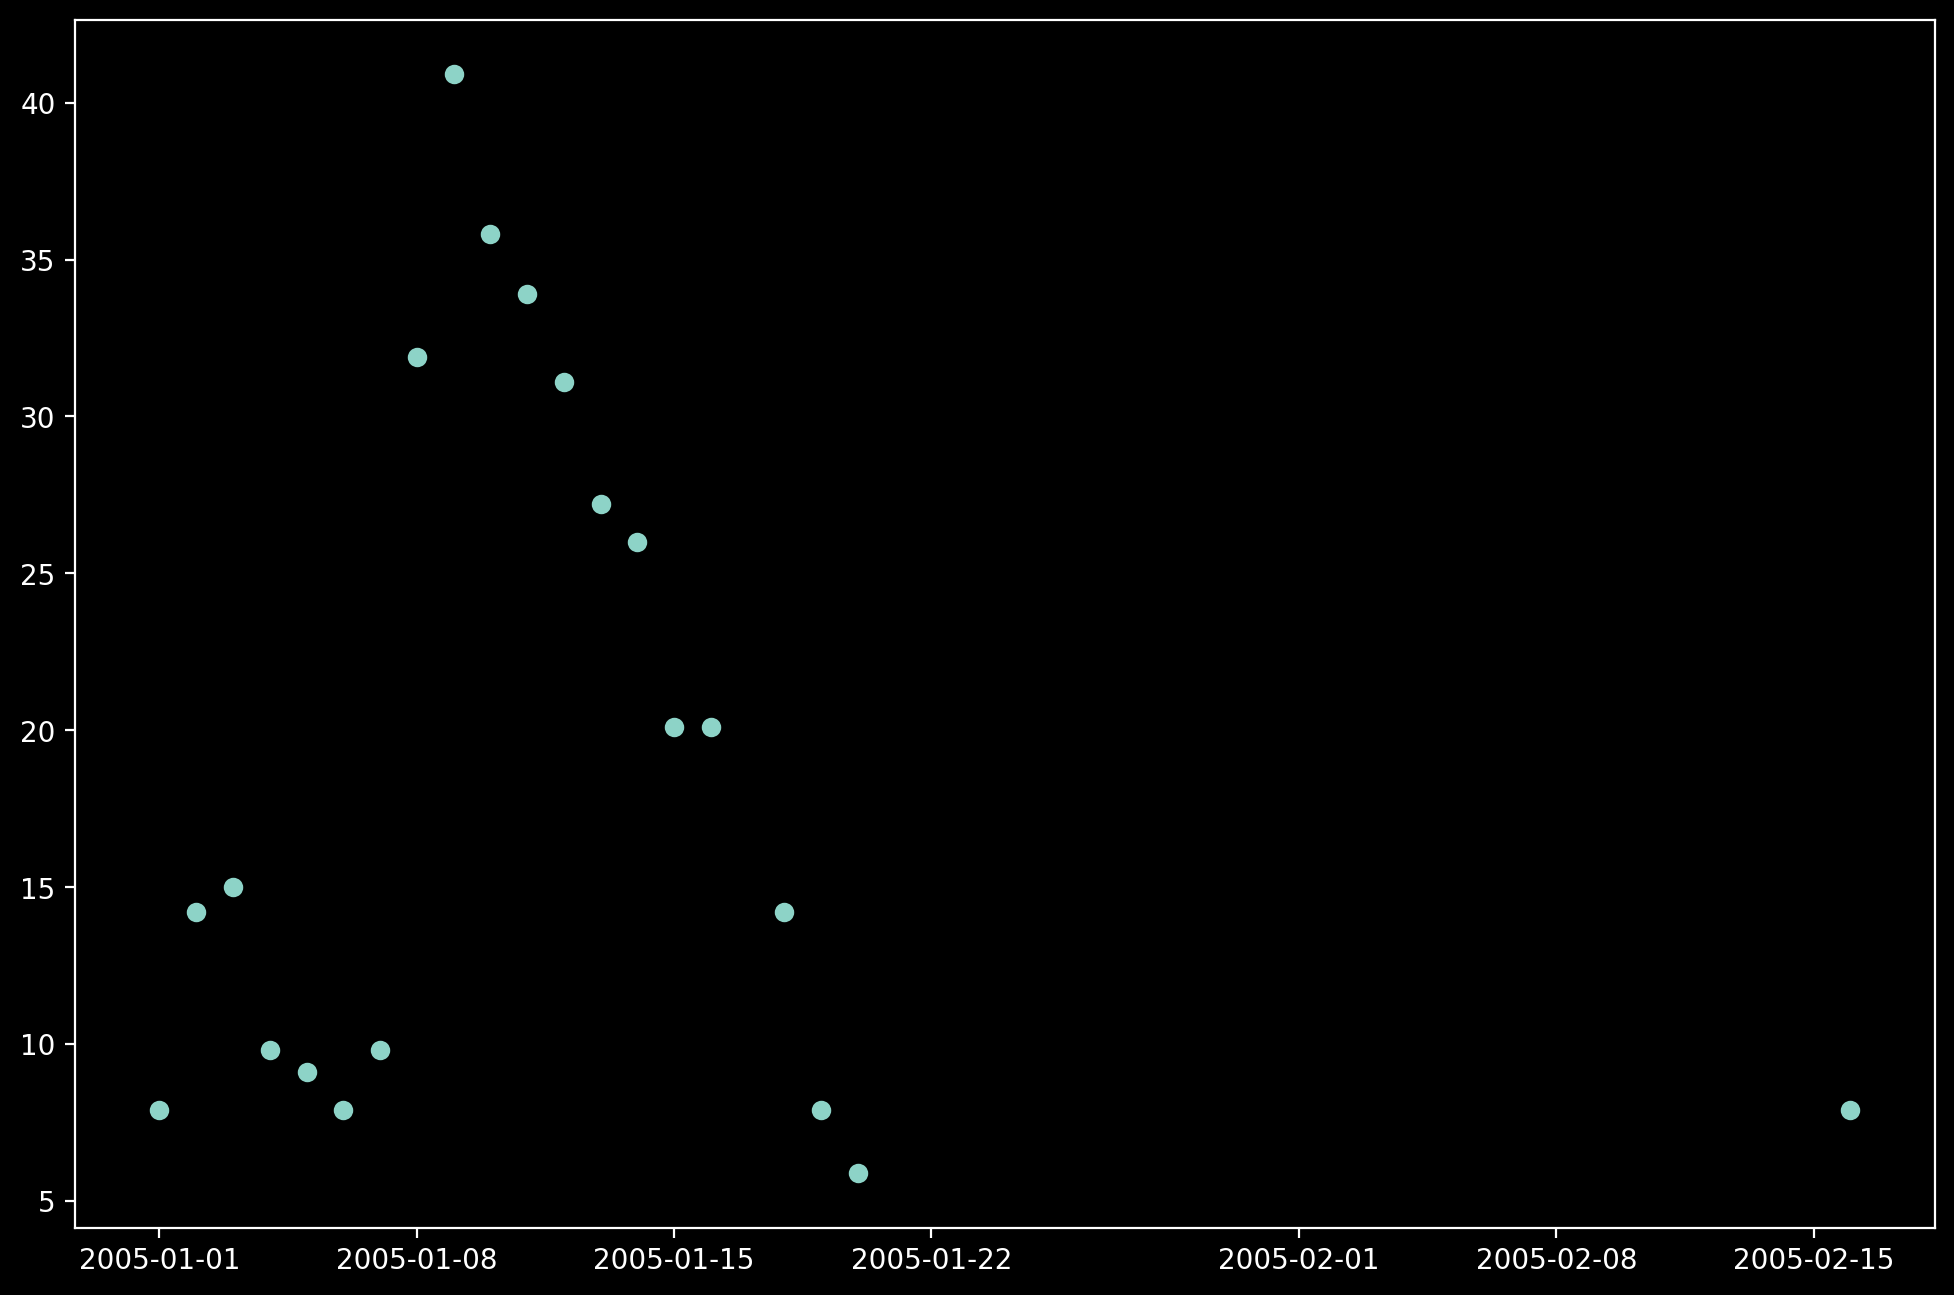

In [79]:
# Quick check for snow_depth. Snow data is available only for January, which makes this already better than the snow column.
# This has data all over the year
df_tmp = df_original[df_original['station_number'] == 725975]
ax = plt.gca()
ax.xaxis_date()
plt.scatter(df_tmp['date'], df_tmp['snow_depth'])

### Trees
Even though a time series model might be appropriate, I don't think that wee need advanced models such as SARIMA. From experience snowfall is seasonal, and simply predicting the probability of snow by month and temperature will therefore already be a pretty good model. Trees can capture this. 

There's no good proxy to predict snow and just for the sage of this challenge, I'll ignore that the column is useless and fit a tree.

Once again, the stations will be treated independently, and we have to fit a tree per station. Since they're geographically distributed it's possible that the seasons are shifted and that for some e.g. January is summer and for others winter.

Code taken from: https://scikit-learn.org/stable/modules/tree.html

In [80]:
# cell to test out and get everything running
df_tmp = df[df['station_number'] == df['station_number'].iloc[0]]
# We skip day to avoid overfitting, and year as this probably has no relation to the seasonality and only impacts the trend of the data (global warming :( )
# additional feature which might help could be the number of the week
X = df_tmp[['month', 'mean_temp', 'mean_dew_point', 'mean_sealevel_pressure', 'mean_visibility', 'mean_wind_speed', 'max_temperature', 'total_precipitation']].to_numpy()
Y = df_tmp[['snow']].to_numpy().flatten().astype('bool')
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

#tree.plot_tree(clf)

The next step would be cross-validation to find a good tree depth and relevant features. At this step, the Markov chain can be considered the naive model and the tree a more sophisticated one, and we should check whether the tree outperforms it.

Additional steps such as pruning, boosting, or bagging will also be done here.

Lastly, the holdout set from before should be used here to give a more unbiased estimate of the model performance. Since the data is not suitable for snow prediction, it's useless to do this now.